### CD4 T cell KO example

This notebook prepares a dataset with 24 individual knockout experiments applied to CD4 T cells ([Freimer et al 2020](https://www.nature.com/articles/s41588-022-01106-y)). Each knockout was profiled with both ATAC and RNA-seq measurements, but we use only RNA. The data have UMI's. Controls are 8 guide RNA's targeting the "safe-harbor" AAVS1 locus, and are labeled `AAVS1_1`, `AAVS1_8`, etc. The experiment was done separately on blood from 3 different donors.

Here we tidy the dataset and carry out a simple exploration in scanpy. (It's not single cell data but scanpy is still useful for data exploration.)

In [23]:
import warnings
warnings.filterwarnings('ignore')
import regex as re
import os
import shutil
import importlib
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
from scipy.stats import spearmanr as spearmanr
from IPython.display import display, HTML

import os, sys
import itertools as it
from scipy.stats import spearmanr, pearsonr, rankdata, f_oneway
from statsmodels.stats.multitest import multipletests
from sklearn.metrics import mutual_info_score
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# local
import importlib
import sys
sys.path.append("setup")
import ingestion
importlib.reload(ingestion)

#      visualization settings
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
plt.rcParams['figure.figsize'] = [6, 4.5]
plt.rcParams["savefig.dpi"] = 300

# Specify the working directory explicitly.
os.chdir("/home/ekernf01/Desktop/jhu/research/projects/perturbation_prediction/cell_type_knowledge_transfer/perturbation_data")

# Universal
geneAnnotationPath = "../accessory_data/gencode.v35.annotation.gtf.gz"       # Downloaded from https://www.gencodegenes.org/human/release_35.html
humanTFPath = "../accessory_data/humanTFs.csv"                               # Downloaded from http://humantfs.ccbr.utoronto.ca/download.php
humanEpiPath = "../accessory_data/epiList.csv"                               # Downloaded from https://epifactors.autosome.org/description 

# Freimer Specific
rawDataPath = "not_ready/freimer/GSE171677_RNA_UMI_dedup_counts.txt"
perturbEffectTFOnlyPath = "setup/freimerTFOnly.csv"                         # a path to store temp file
perturbEffectFullTranscriptomePath = "setup/freimerFullTranscriptome.csv"   # a path to store temp file

finalDataFileFolder = "perturbations/freimer"
finalDataFilePath   = "perturbations/freimer/test.h5ad"

### Reshape the data

In [24]:
expression_quantified = pd.read_csv(rawDataPath, 
                                    delimiter="\t",
                                    index_col=0, 
                                    header=0, 
                                    comment='!')   
gene_metadata   = expression_quantified.iloc[:,0:5]
expression_quantified = expression_quantified.iloc[:, 5:].T
sample_metadata = pd.DataFrame(columns = ["donor", "perturbation"], 
                               index = expression_quantified.index,
                               data = [g.split("_", maxsplit=2)[1:3] for g in expression_quantified.index])
print("\n\ngene_metadata\n")
display(gene_metadata.head())
print("\n\nsample_metadata\n")
display(sample_metadata.head())
print("\n\n expression_quantified\n")
display(expression_quantified.head().T.head())



gene_metadata



,Chr,Start,End,Strand,Length
Geneid,,,,,
ENSG00000223972.5,chr1;chr1;chr1;chr1;chr1;chr1;chr1;chr1;chr1,11869;12010;12179;12613;12613;12975;13221;1322...,12227;12057;12227;12721;12697;13052;14409;1337...,+;+;+;+;+;+;+;+;+,1735
ENSG00000227232.5,chr1;chr1;chr1;chr1;chr1;chr1;chr1;chr1;chr1;c...,14404;15005;15796;16607;16858;17233;17606;1791...,14501;15038;15947;16765;17055;17368;17742;1806...,-;-;-;-;-;-;-;-;-;-;-,1351
ENSG00000278267.1,chr1,17369,17436,-,68
ENSG00000243485.5,chr1;chr1;chr1;chr1;chr1,29554;30267;30564;30976;30976,30039;30667;30667;31097;31109,+;+;+;+;+,1021
ENSG00000284332.1,chr1,30366,30503,+,138




sample_metadata



,donor,perturbation
Donor_1_AAVS1_4,1,AAVS1_4
Donor_1_STAT5B,1,STAT5B
Donor_1_AAVS1_7,1,AAVS1_7
Donor_1_TNFAIP3,1,TNFAIP3
Donor_1_MYB,1,MYB




 expression_quantified



,Donor_1_AAVS1_4,Donor_1_STAT5B,Donor_1_AAVS1_7,Donor_1_TNFAIP3,Donor_1_MYB
Geneid,,,,,
ENSG00000223972.5,0,0,0,0,0
ENSG00000227232.5,0,0,0,0,1
ENSG00000278267.1,0,0,0,0,0
ENSG00000243485.5,0,0,0,0,0
ENSG00000284332.1,0,0,0,0,0


### Combine into anndata to keep everything together

In [25]:
expression_quantified = sc.AnnData(expression_quantified, 
                                   var = gene_metadata.copy(),
                                   obs = sample_metadata.copy())
expression_quantified.raw = expression_quantified.copy()
# DRY these up once they're in AnnData
del gene_metadata
del sample_metadata

### Convert ensembl gene id's to gene symbol

In [26]:
expression_quantified.var_names = ingestion.convert_ens_to_symbol(expression_quantified.var_names, 
                                                                  gtf=geneAnnotationPath)
display(expression_quantified.var.head())
display(expression_quantified.var_names[0:5])

,Chr,Start,End,Strand,Length
DDX11L1,chr1;chr1;chr1;chr1;chr1;chr1;chr1;chr1;chr1,11869;12010;12179;12613;12613;12975;13221;1322...,12227;12057;12227;12721;12697;13052;14409;1337...,+;+;+;+;+;+;+;+;+,1735
WASH7P,chr1;chr1;chr1;chr1;chr1;chr1;chr1;chr1;chr1;c...,14404;15005;15796;16607;16858;17233;17606;1791...,14501;15038;15947;16765;17055;17368;17742;1806...,-;-;-;-;-;-;-;-;-;-;-,1351
MIR6859-1,chr1,17369,17436,-,68
MIR1302-2HG,chr1;chr1;chr1;chr1;chr1,29554;30267;30564;30976;30976,30039;30667;30667;31097;31109,+;+;+;+;+,1021
MIR1302-2,chr1,30366,30503,+,138


Index(['DDX11L1', 'WASH7P', 'MIR6859-1', 'MIR1302-2HG', 'MIR1302-2'], dtype='object')

In [27]:
# Document controls with weird names
controls = [f"AAVS1_{i}" for i in range(1,9)]
for c in controls:
    assert c in expression_quantified.obs['perturbation'].unique() 
expression_quantified.obs["is_control"] = expression_quantified.obs['perturbation'].isin(controls)
expression_quantified.obs["is_control_int"] = expression_quantified.obs['perturbation'].isin(controls).astype(int)

### Retain genes w/ a minimum count in at least 3 samples

In [28]:
minCount = np.ceil(10/min(expression_quantified.X.sum(axis=1))/1e-6)
retainColumn = (np.sum(expression_quantified.X > minCount, axis=0) > 3)
expression_quantified._n_vars = np.sum(retainColumn)
expression_quantified.X = expression_quantified.X[:, retainColumn]
expression_quantified.var = expression_quantified.var.iloc[retainColumn]
expression_quantified

AnnData object with n_obs × n_vars = 96 × 14299
    obs: 'donor', 'perturbation', 'is_control', 'is_control_int'
    var: 'Chr', 'Start', 'End', 'Strand', 'Length'

In [29]:
retainRows = ~(expression_quantified.obs.index == 'Donor_4_AAVS1_6')
expression_quantified._n_obs = np.sum(retainRows)
expression_quantified.X = expression_quantified.X[retainRows, :]
expression_quantified.obs = expression_quantified.obs.iloc[retainRows]
expression_quantified

AnnData object with n_obs × n_vars = 95 × 14299
    obs: 'donor', 'perturbation', 'is_control', 'is_control_int'
    var: 'Chr', 'Start', 'End', 'Strand', 'Length'

In [30]:
def RPKM(mat: np.ndarray, geneLength: np.ndarray):
    """
    Expects 
    Args:
        mat: gene expression matrix with shape (n_obs, n_var)
        geneLength: gene length vector with shape (n_var,)
    """
    assert geneLength.shape[0] == mat.shape[1]
    assert geneLength.shape
    return mat * 1e3 * 1e6 / mat.sum(axis=1, keepdims=True) / geneLength[np.newaxis,:]

expression_quantified.X = RPKM(expression_quantified.X + 0.5, expression_quantified.var.Length)

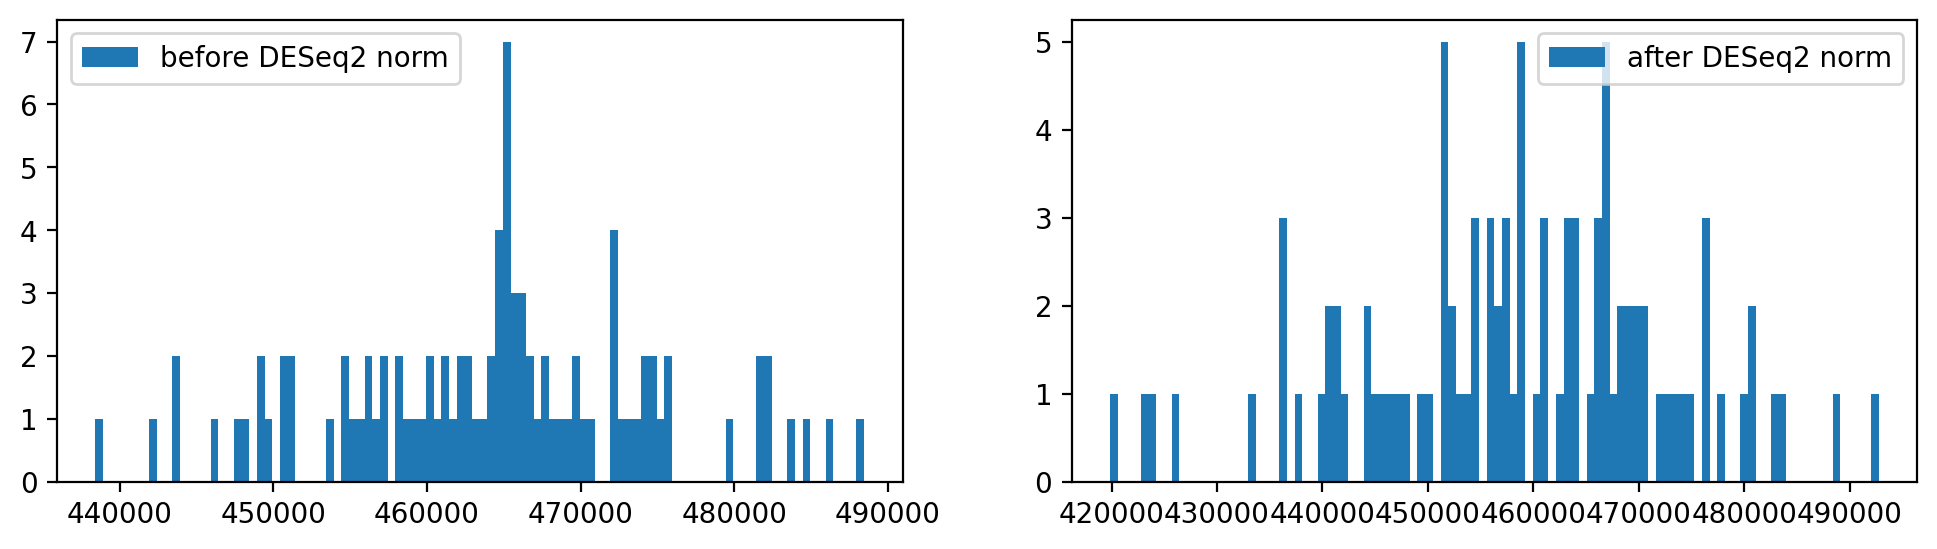

In [31]:
""" Sanity Check:
The sum of gene expression before and after normalization """
fig, axes = plt.subplots(1, 2, figsize=(12,3))
axes[0].hist(expression_quantified.X.sum(axis=1), bins=100, log=False, label="before DESeq2 norm")
axes[1].hist(ingestion.deseq2Normalization(expression_quantified.X.T).T.sum(axis=1), bins=100, log=False, label="after DESeq2 norm")
axes[0].legend()
axes[1].legend()
plt.show()

### Normalization on bulk

In [32]:
expression_quantified.X = ingestion.deseq2Normalization(expression_quantified.X.T).T

### Exp

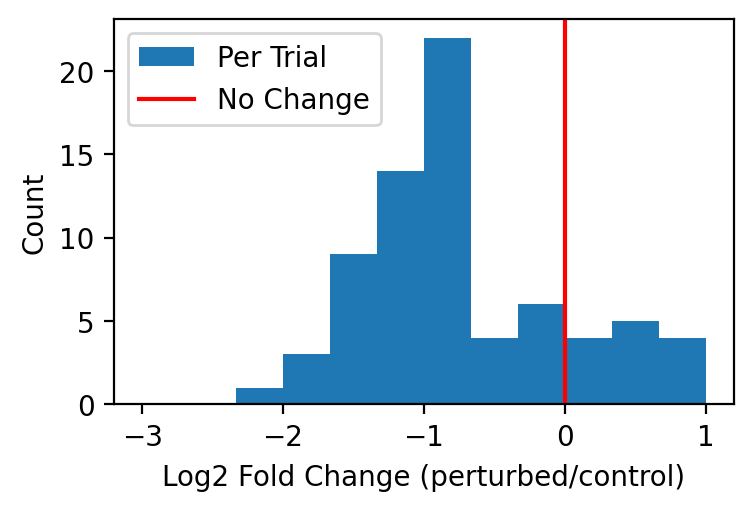

Counter({'NA': 23, 'Yes': 59, 'No': 13})

In [33]:
# If verbose is set to True, display disconcordant trials and their controls
status, logFC = ingestion.checkConsistency(expression_quantified, 
                                           perturbationType="knockdown", 
                                           group="donor",
                                           verbose=False) 
expression_quantified.obs["consistentW/Perturbation"] = status
expression_quantified.obs["logFC"] = logFC
Counter(status)

[21 57 91] ATXN7L3
[25 60 94] CBFB
[23 58 92] ETS1
[34 69 77] FOXK1
[12 47 81] FOXP1
[30 44 65] GATA3
[ 8 43 78] HIVEP2
[13 48 82] IL2RA
[16 51 85] IRF1
[ 9 45 79] IRF2
[24 59 93] IRF4
[15 50 84] JAK3
[29 33 64] KLF2
[18 53 88] KMT2A
[20 56 90] MBD2
[17 52 86] MED12
[ 4 39 74] MYB
[32 66 68] PTEN
[11 27 62] RELA
[ 6 41 76] STAT5A
[ 1 36 71] STAT5B
[ 3 38 73] TNFAIP3
[ 5 40 75] YY1
[31 55 67] ZNF217


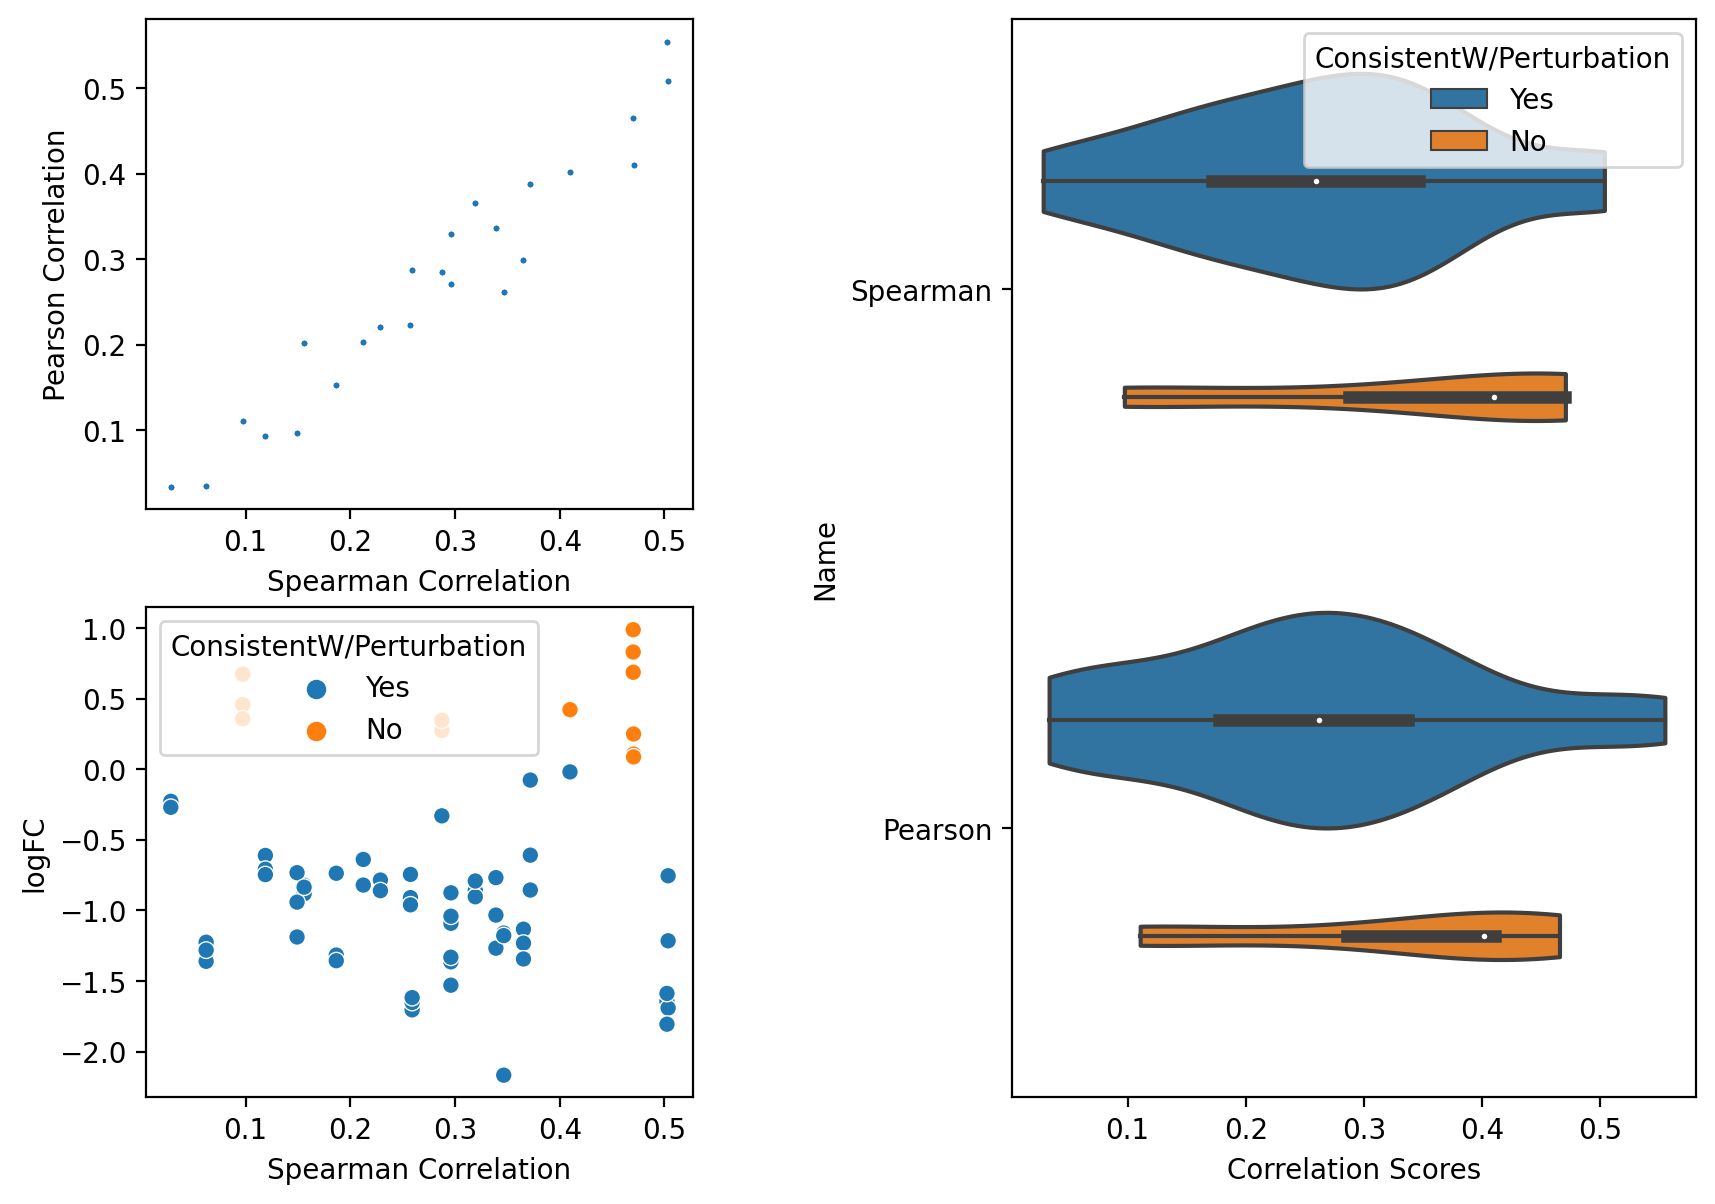

In [34]:
correlations = ingestion.computeCorrelation(expression_quantified, verbose=True, group="donor")
expression_quantified.obs["spearmanCorr"] = correlations[0]
expression_quantified.obs[ "pearsonCorr"] = correlations[1]

In [35]:
"""
Downloaded from http://humantfs.ccbr.utoronto.ca/download.php """
TFList = pd.read_csv(humanTFPath, index_col=0).iloc[:, [1,3]]
TFDict = dict([tuple(i) for i in TFList.to_numpy().tolist() if i[1] == 'Yes'])

"""
Downloaded from https://epifactors.autosome.org/description """
EpiList = pd.read_csv(humanEpiPath, index_col=0).iloc[:, [0,14]]
EpiDict = dict([tuple(i) for i in EpiList.to_numpy().tolist()])

In [36]:
""" If want to look at bigness on TF only """
TFVar = [i for i,p in enumerate(expression_quantified.var.index) if p in TFDict or p in EpiDict]
expression_quantifiedTFOnly = expression_quantified[:, TFVar].copy()
ingestion.quantifyEffect(adata=expression_quantifiedTFOnly, 
                         fname=perturbEffectTFOnlyPath, 
                         group=None, 
                         diffExprFC=False, 
                         prefix="TFOnly")

ingestion.quantifyEffect(adata=expression_quantified, 
                         fname=perturbEffectFullTranscriptomePath, 
                         group=None,
                         diffExprFC=False, 
                         prefix="")

listOfMetrics = ["DEG", "MI", "logFCMean", "logFCNorm2", "logFCMedian"]
for m in listOfMetrics:
    expression_quantified.obs[f"TFOnly{m}"] = expression_quantifiedTFOnly.obs[f"TFOnly{m}"]

1620
0 ATXN7L3 379.0 0.2717994782874337 0.1919696076760615 16.474976485338804 2.2521255812934378
1 CBFB 406.0 0.3190252326975705 0.1812623603307822 21.873870475945704 2.212426726828671
2 ETS1 129.0 0.2206229300602662 0.1393736769744444 14.537515857019605 2.32333591443316
3 FOXK1 11.0 0.1718048209468988 0.1076326934435077 10.636494074685336 2.4166191855968946
4 FOXP1 17.0 0.1818745251445008 0.1141181700440055 11.766564394737127 2.4464564442011323
5 GATA3 76.0 0.1990389100684009 0.1349358944228265 12.09219201440218 2.407302638864992
6 HIVEP2 0.0 0.1451437633766876 0.0892908351996235 9.739098586608554 2.532428222268005
7 IL2RA 303.0 0.2511272102589924 0.1779368562048617 14.687796692694372 2.348825493121158
8 IRF1 14.0 0.1594436801411594 0.1007609071774639 10.6703791355276 2.525948832213264
9 IRF2 19.0 0.1780158807180762 0.0971695067089654 12.732462953326284 2.4582673777861768
10 IRF4 384.0 0.2888583804383968 0.1946849405800577 17.591064151912466 2.2057966946476766
11 JAK3 53.0 0.185007633

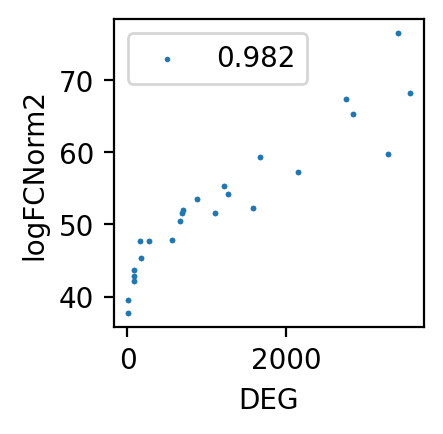

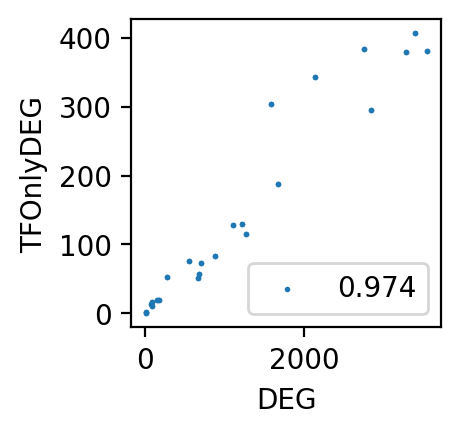

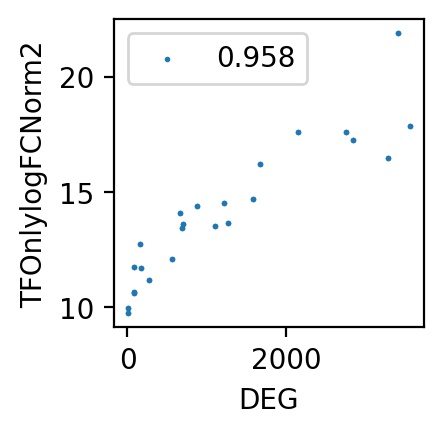

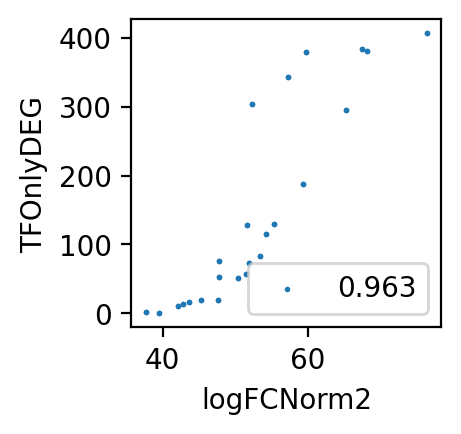

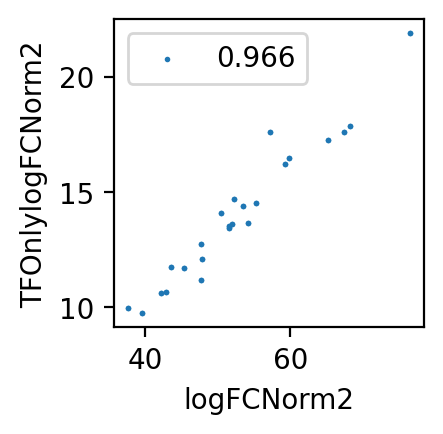

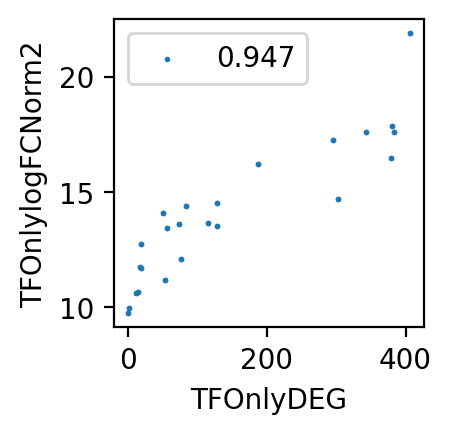

In [37]:
metricOfInterest = ["DEG", "logFCNorm2", "TFOnlyDEG", "TFOnlylogFCNorm2"]
ingestion.checkPerturbationEffectMetricCorrelation(expression_quantified, metrics=metricOfInterest)

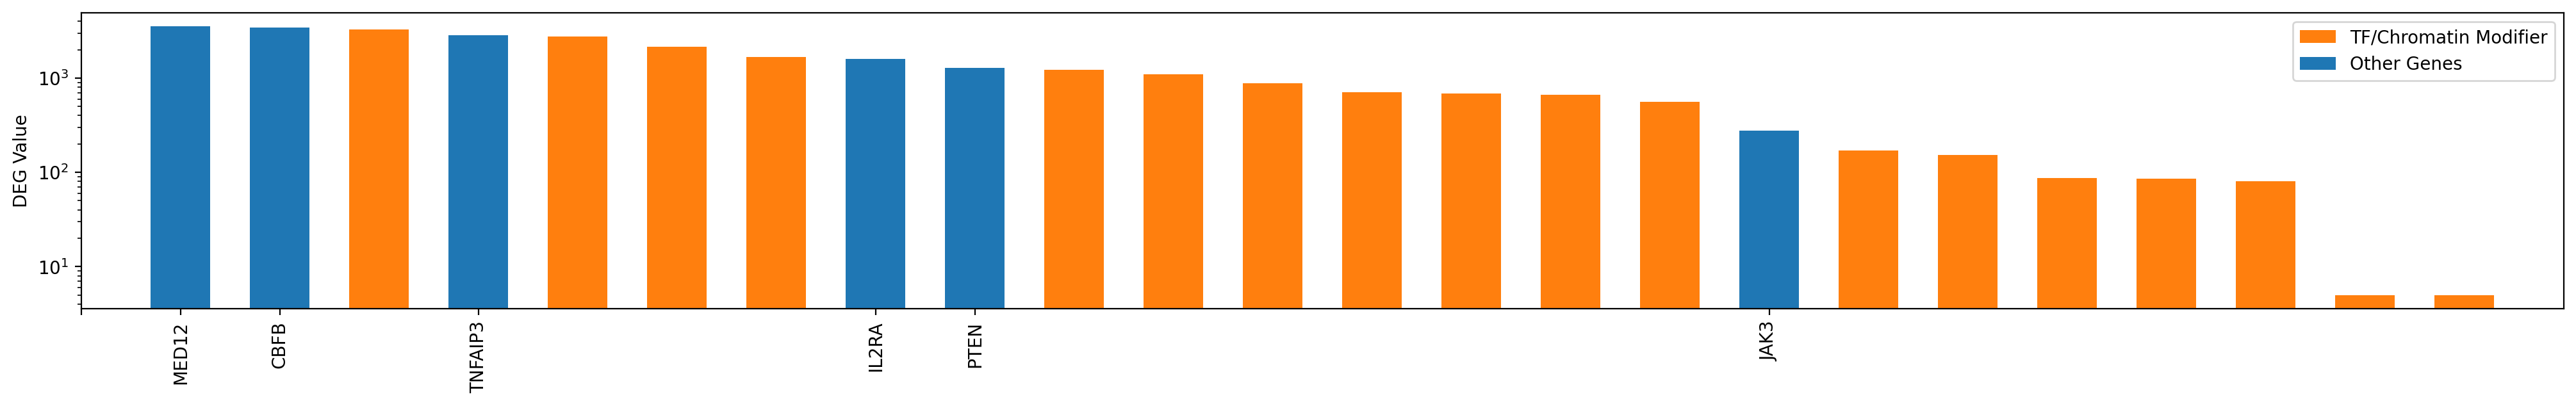

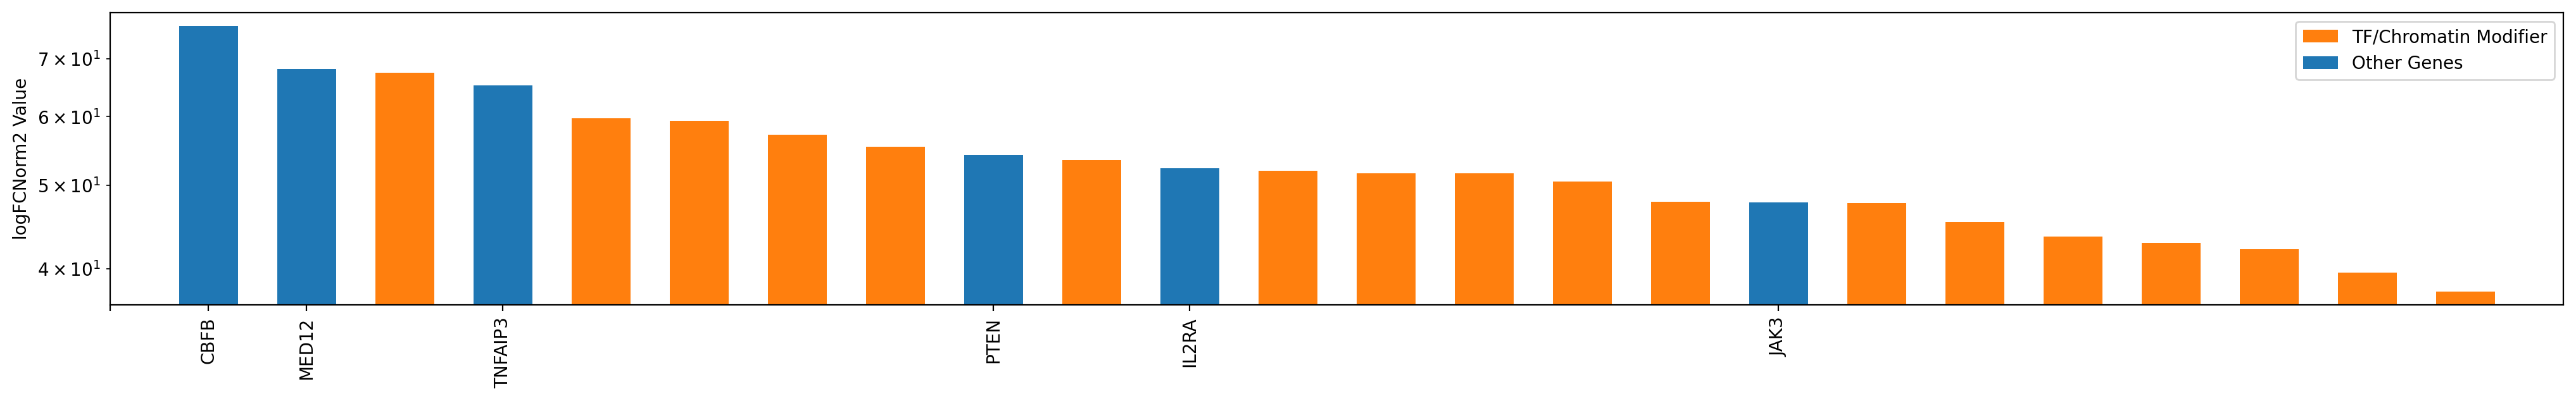

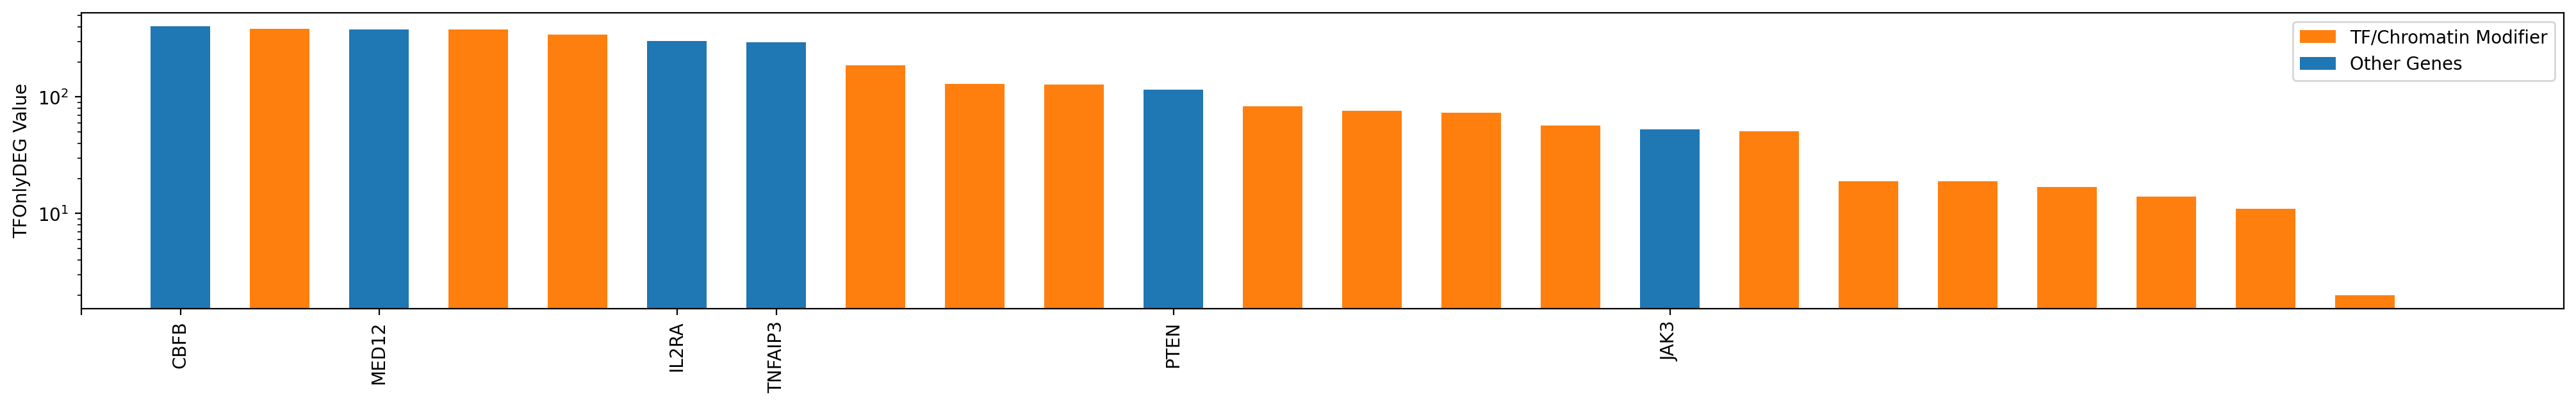

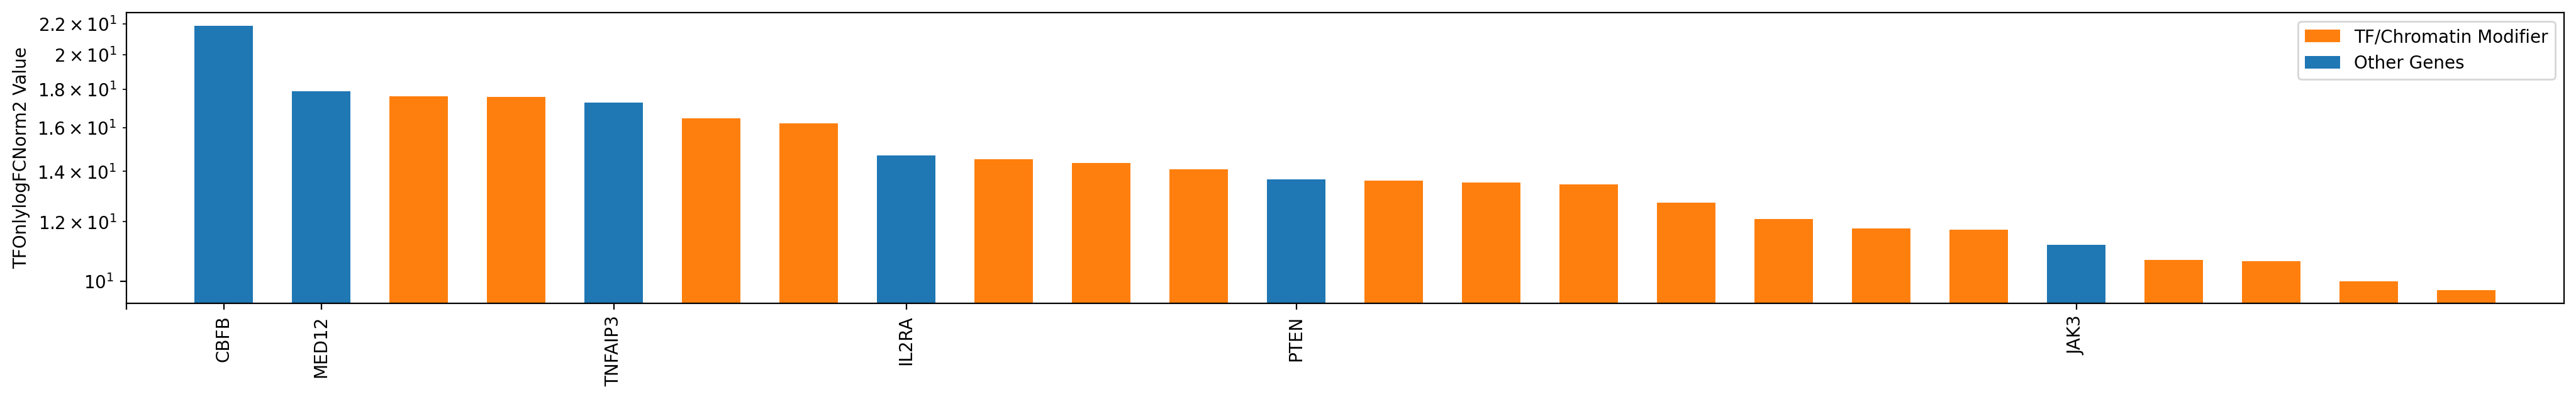

In [38]:
ingestion.visualizePerturbationEffect(expression_quantified, metrics=metricOfInterest, TFDict=TFDict, EpiDict=EpiDict)

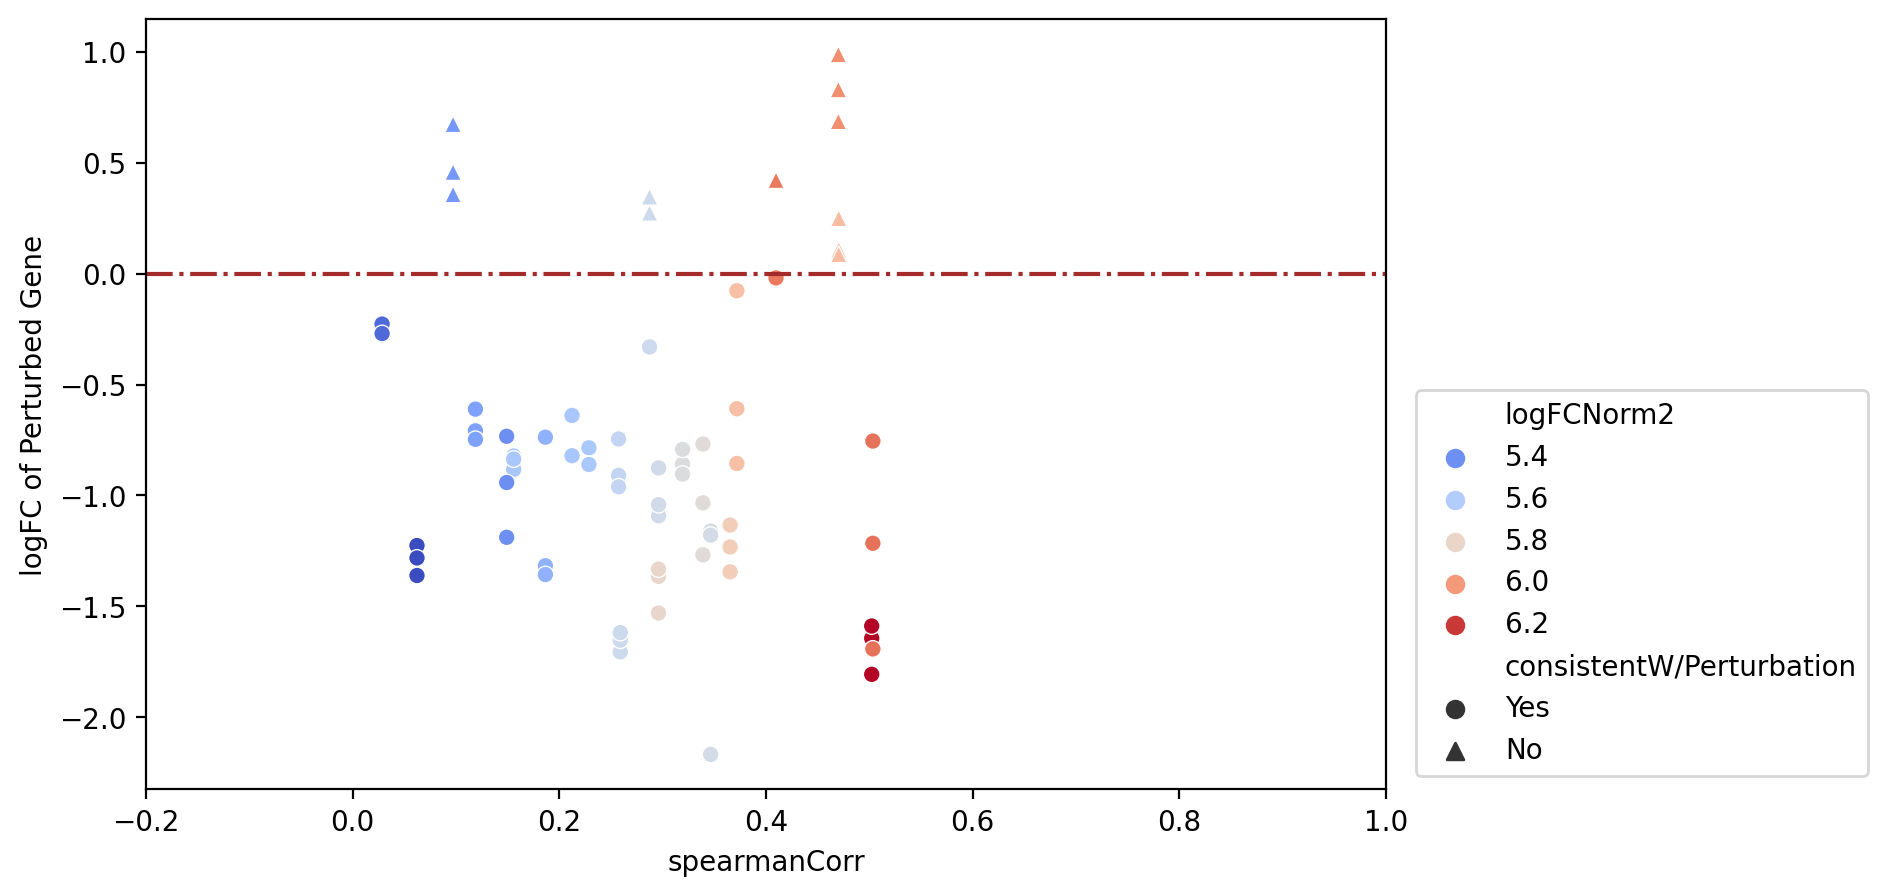

In [39]:
temp = expression_quantified.copy()

""" If you wish to see the magnitude of perturbation effect more clearer,
    i.e. a smoother gradient of the color shift, feel free to uncomment
    the line below, which takes the log of the norm2 """
temp.obs['logFCNorm2'] = np.log2(temp.obs['logFCNorm2'])

ingestion.visualizePerturbationMetadata(temp,
                                        x="spearmanCorr", 
                                        y="logFC", 
                                        style="consistentW/Perturbation", 
                                        hue="logFCNorm2", 
                                        markers=['o', '^'], 
                                        xlim=[-0.2, 1])

(PearsonRResult(statistic=0.98, pvalue=6.433880300790172e-17),
 SpearmanrResult(correlation=0.9799999999999999, pvalue=6.43388030079055e-17))

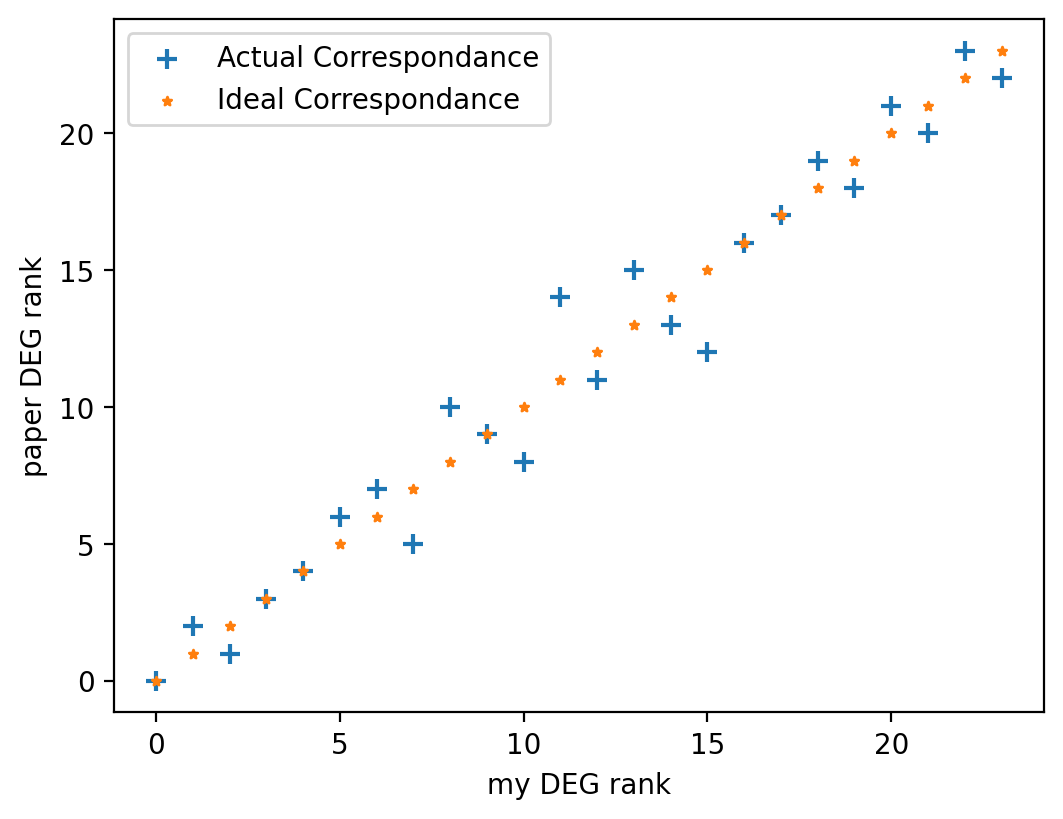

In [40]:
keepRow      = (~expression_quantified.obs.perturbation.duplicated() & (~expression_quantified.obs.is_control)) 
perturbagens = expression_quantified[keepRow].obs.perturbation
myDEG        = expression_quantified[keepRow].obs.DEG
myOrder      = np.array(perturbagens)[np.argsort(myDEG)[::-1]]

# Taken from Extended Figure 3d of the paper https://www.nature.com/articles/s41588-022-01106-y/figures/10
theirOrder = ['MED12', 'ATXN7L3', 'CBFB', 'TNFAIP3', 'IRF4', 'IL2RA', 'YY1', 'MYB',
 'KLF2', 'ETS1', 'PTEN', 'STAT5B', 'GATA3', 'KMT2A', 'ZNF217', 'MBD2', 
 'JAK3', 'STAT5A', 'FOXK1', 'IRF2', 'IRF1', 'FOXP1', 'RELA', 'HIVEP2']

theirInMyOrderPos = [np.where(myOrder==i)[0][0] for i in theirOrder]
plt.scatter(theirInMyOrderPos, range(24), s=50, marker='+', label="Actual Correspondance")
plt.scatter(range(24)        , range(24), s=10, marker="*", label="Ideal Correspondance")
plt.xlabel("my DEG rank")
plt.ylabel("paper DEG rank")
plt.legend()
(pearsonr (theirInMyOrderPos, range(24)), spearmanr(theirInMyOrderPos, range(24)))

### Basic EDA

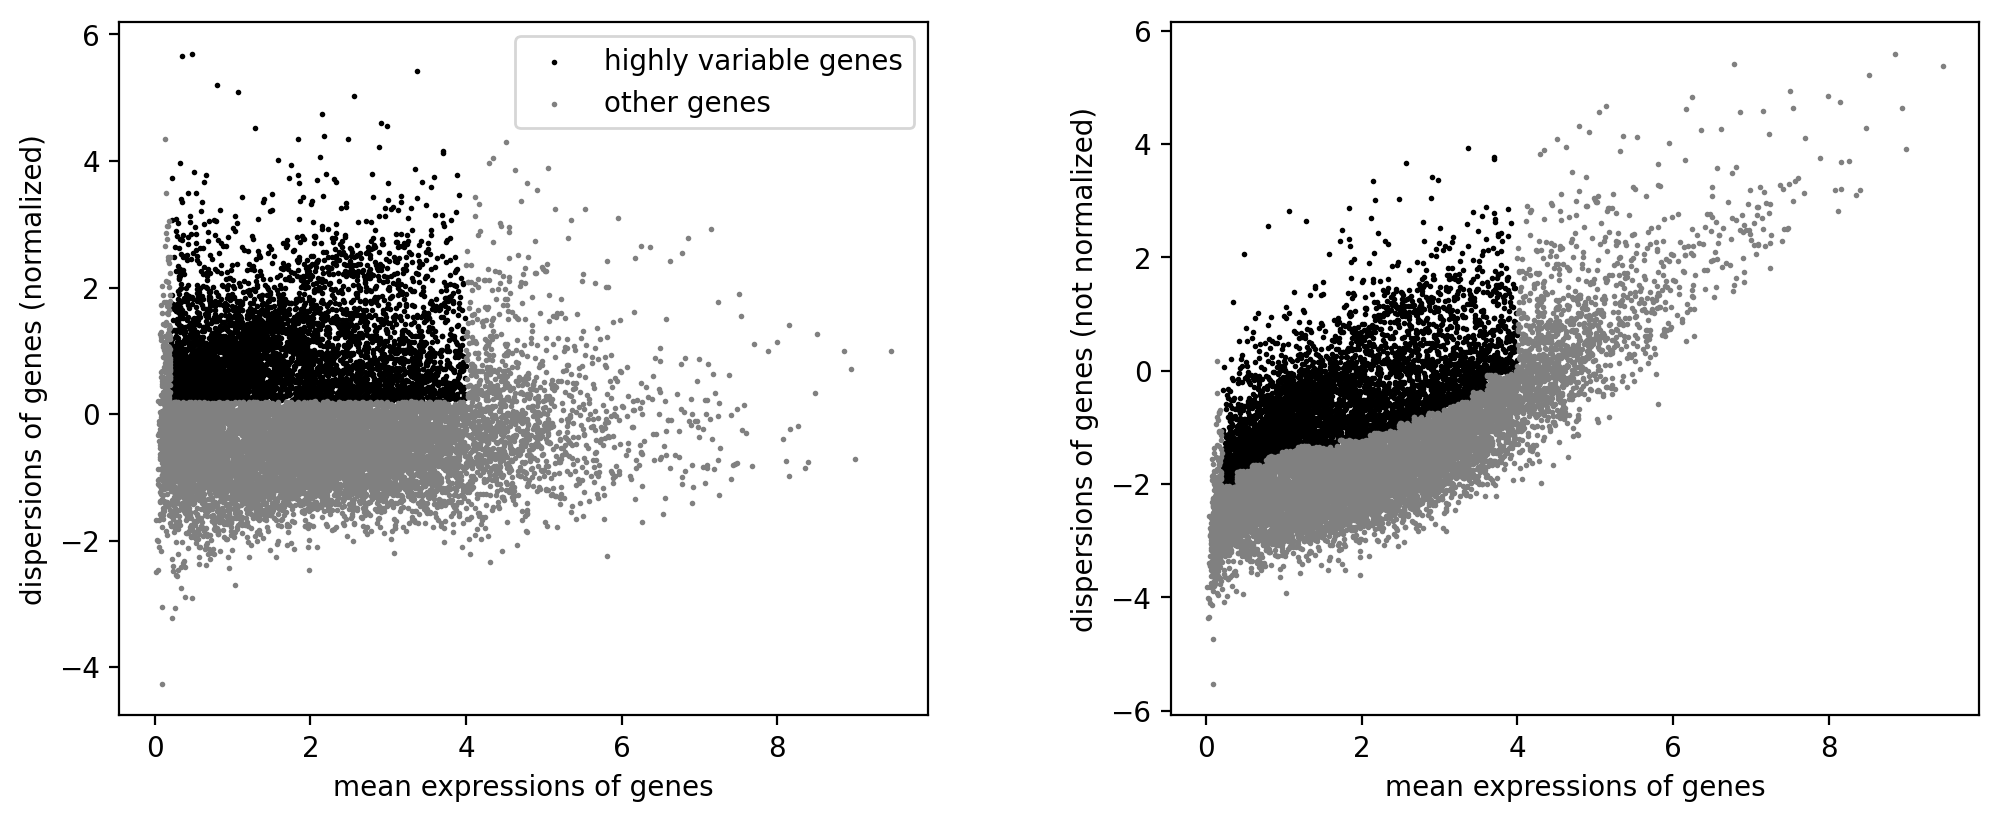

In [41]:
# sc.pp.normalize_total(expression_quantified, target_sum=1e4)
sc.pp.log1p(expression_quantified)
sc.pp.highly_variable_genes(expression_quantified, min_mean=0.2, max_mean=4, min_disp=0.2, n_bins=50)
sc.pl.highly_variable_genes(expression_quantified)
with warnings.catch_warnings():
    sc.tl.pca(expression_quantified, n_comps=5)
sc.pp.neighbors(expression_quantified)
sc.tl.umap(expression_quantified)
clusterResolutions = []


In [42]:
expression_quantified.var_names

Index(['MTND1P23', 'MTND2P28', 'MTCO1P12', 'MTCO2P12', 'MTATP8P1', 'MTATP6P1',
       'MTCO3P12', 'LINC01409', 'AL669831.4', 'LINC01128',
       ...
       'MT-ND4L', 'MT-ND4', 'MT-TH', 'MT-TS2', 'MT-TL2', 'MT-ND5', 'MT-ND6',
       'MT-CYB', 'MT-TT', 'MT-TP'],
      dtype='object', length=14299)

In [43]:
"CTLA4" in set(expression_quantified.var.index)

True

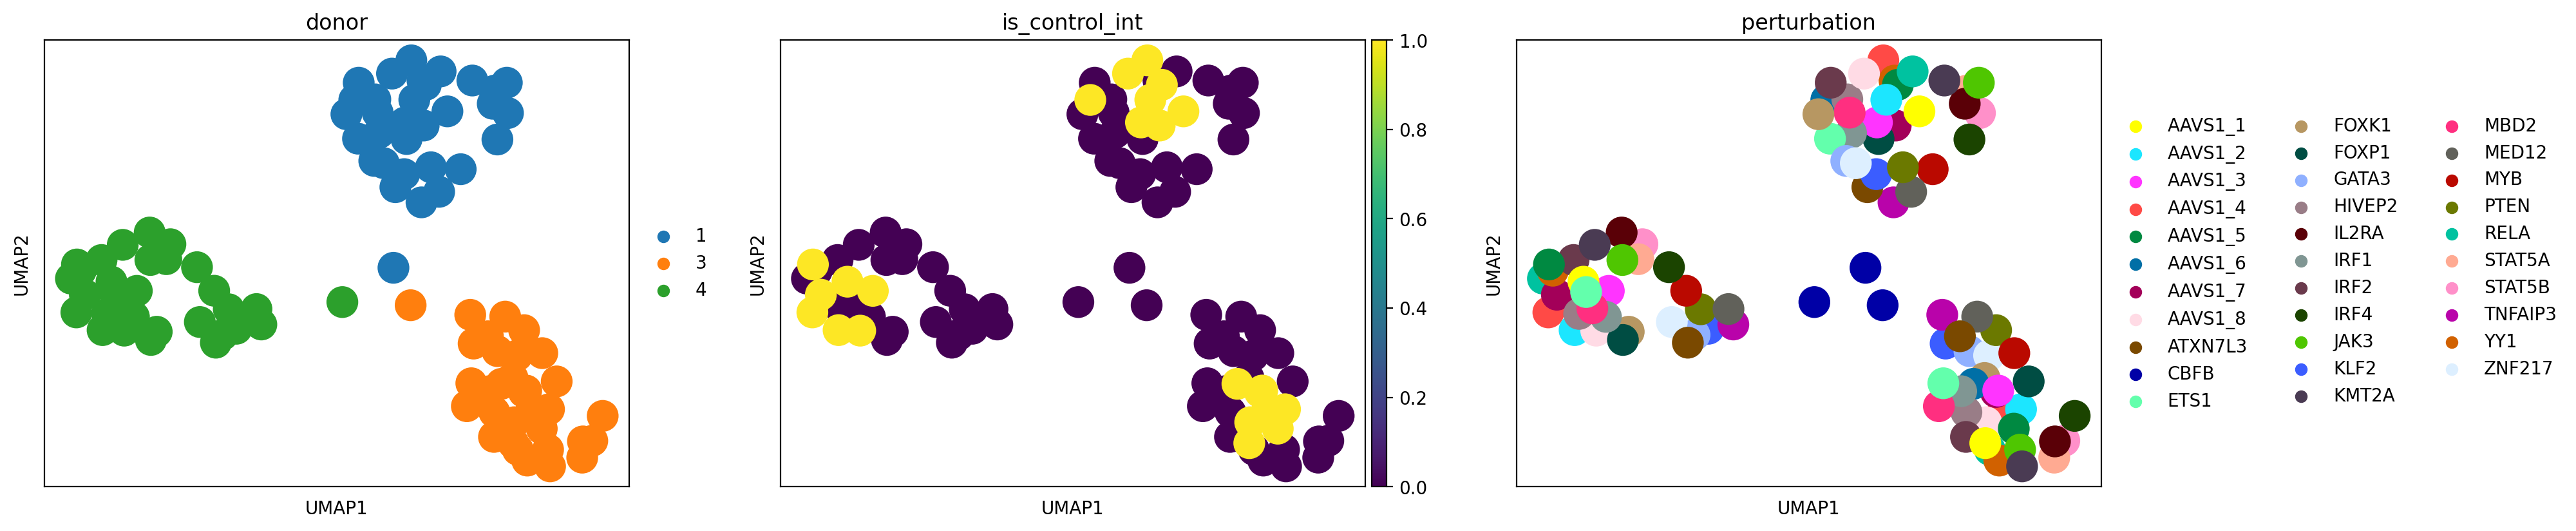

Some plots are missing due to a weird scanpy KeyError on genes "IL2RA", "IL2", "CTLA4".


<Figure size 2061x450 with 0 Axes>

In [44]:
sc.pl.umap(expression_quantified, color = ["donor", "is_control_int", "perturbation"])
try:
    sc.pl.umap(expression_quantified, color = ["IL2RA", "IL2", "CTLA4"])
except KeyError:
    print('Some plots are missing due to a weird scanpy KeyError on genes "IL2RA", "IL2", "CTLA4".')
# Due to the small number of samples, ask CO to use only one cluster.
# Requires setting certain other undocumented aspects of object state. :(
expression_quantified.obs["fake_cluster"]="all_one_cluster"
expression_quantified.obs.fake_cluster = expression_quantified.obs.fake_cluster.astype("category")
expression_quantified.uns["fake_cluster_colors"] = ['#1f77b4']

### Data reduction

With only 64GB of RAM, I have been unable to make whole-transcriptome predictions with CellOracle. A data reduction step is necessary where only highly variable genes are included. We also keep all genes that are perturbed, whether or not they appear highly variable -- unless they are unavailable in the first place. 

In [45]:
perturbed_genes = set(list(expression_quantified.obs['perturbation'].unique())).difference(controls)
perturbed_and_measured_genes = perturbed_genes.intersection(expression_quantified.var.index)
perturbed_but_not_measured_genes = perturbed_genes.difference(expression_quantified.var.index)
genes_keep = expression_quantified.var.index[expression_quantified.var['highly_variable']]
genes_keep = set(genes_keep).union(perturbed_and_measured_genes)
expression_quantified_orig = expression_quantified.copy()
print("These genes were perturbed but not measured:")
print(perturbed_but_not_measured_genes)
print("This many variable genes will be kept and used by CO:")
print(len(genes_keep))

These genes were perturbed but not measured:
set()
This many variable genes will be kept and used by CO:
4623


In [46]:
# final form, ready to save
expression_quantified = expression_quantified_orig[:,list(genes_keep)]
expression_quantified.uns["perturbed_and_measured_genes"]     = list(perturbed_and_measured_genes)
expression_quantified.uns["perturbed_but_not_measured_genes"] = list(perturbed_but_not_measured_genes)
expression_quantified = ingestion.describe_perturbation_effect(expression_quantified, "knockout")

### Final QC Conclusion

In [47]:
""" No Filtering """

expression_quantified = expression_quantified.copy()

In [48]:
os.makedirs(finalDataFileFolder, exist_ok = True)
expression_quantified.write_h5ad(finalDataFilePath)